In [1]:
import numpy as np
from math import cos, sin
import sys
from PIL import Image, ImageDraw, ImageColor
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

In [2]:
from util_functions import cutoffPercentile, createXZGrid

In [3]:
I = 1 # 1 amp of current flowing through coil
mu0 = 4 *np.pi*10**(-7)  # magnetic permeability constant
radius = 1  # radius of coil in meters
#bbox = (-.05,-.05, -.05, .05, .05, .05)  # bounding box of visual area in meters
bbox = (0,0, 10, 10)  # bounding box of visual area in meters


In [4]:
with open("cellCanvas-jl-100.npy","rb") as f:
    bField = np.load(f)

In [5]:
print (bField.shape)

(100, 100, 100, 3)


In [6]:
doubleShape = tuple( x*2 for x in bField.shape[: - 1]) + (bField.shape[-1],)
cellsCanvas = np.zeros(doubleShape)
meshsize = bField.shape[0]
rgridsize = int(radius/(bbox[2] - bbox[0])*meshsize)+1
cellsCanvas.shape

(200, 200, 200, 3)

In [7]:
print (rgridsize)
print (bField.shape)

11
(100, 100, 100, 3)


In [8]:

cellsCanvas[meshsize:2*meshsize, meshsize:2*meshsize, meshsize:2*meshsize] = bField
cellsCanvas[meshsize-1::-1, meshsize:2*meshsize, meshsize:2*meshsize] = bField
cellsCanvas[meshsize-1::-1, meshsize-1::-1, meshsize:2*meshsize] = bField
cellsCanvas[meshsize:2*meshsize, meshsize-1::-1, meshsize:2*meshsize] = bField
cellsCanvas[meshsize:2*meshsize, meshsize:2*meshsize, 0:meshsize] = bField[:,:,::-1]
cellsCanvas[meshsize-1::-1, meshsize:2*meshsize, 0:meshsize] = bField[:,:,::-1]
cellsCanvas[meshsize-1::-1, meshsize-1::-1, 0:meshsize] = bField[:,:,::-1]
cellsCanvas[meshsize:2*meshsize, meshsize-1::-1, 0:meshsize] = bField[:,:,::-1]

In [9]:
cellsCanvas.shape

(200, 200, 200, 3)

In [10]:
print (cellsCanvas[0:10,0,0])
print (bField[0:10,0,0])

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.          0.          1.56642803]
 [ 0.          0.          1.78215368]
 [ 0.          0.          2.02867004]
 [ 0.          0.          2.31750561]
 [ 0.          0.          2.67008588]
 [ 0.          0.          3.12711506]
 [ 0.          0.          3.77194321]
 [ 0.          0.          4.80203391]
 [ 0.          0.          6.82623291]
 [ 0.          0.         13.16453276]]


In [11]:
bFieldCanvas = cellsCanvas.copy()

In [12]:
%time magnitudes = np.linalg.norm( cellsCanvas , axis=-1)* mu0/(4*np.pi)
magnitudes.shape

CPU times: user 299 ms, sys: 493 ms, total: 792 ms
Wall time: 825 ms


(200, 200, 200)

In [ ]:
%time magnitudes = np.linalg.norm( cellsCanvas , axis=-1)* mu0/(4*np.pi)
magnitudes.shape

In [ ]:
magnitudes[:,:,meshsize].shape

In [ ]:
mags = cutoffPercentile(magnitudes[:,:,meshsize], 99.999)

In [ ]:
fig,ax = plt.subplots()
plt.title("1A Current Circular Coil and Magnetic Field (G)")

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())

im = ax.imshow(mags*10000)  # Convert to Gauss units
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Gauss (G)", rotation=-90, va="bottom")

plt.show()

In [ ]:
cellsCanvas.shape

In [ ]:
mags = cutoffPercentile(magnitudes[meshsize-rgridsize:meshsize+rgridsize,meshsize-rgridsize:meshsize+rgridsize,meshsize], 99.999)

In [ ]:
fig,ax = plt.subplots()
plt.title("1A Current Circular Coil and Magnetic Field (G)")

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())

im = ax.imshow(mags*10000)  # Convert to Gauss units
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Gauss (G)", rotation=-90, va="bottom")

plt.show()

In [ ]:
cellsCanvas = np.zeros(doubleShape)
print ("cells Canvas shape ", cellsCanvas.shape)
print ("bField shape ", bField.shape)
xmax, ymax, zmax, _ = cellsCanvas.shape

xbmax, ybmax, zbmax, _ = bField.shape

# rgridsize is half the coil diameter
print ("coil diameter = ", rgridsize*2)
numxfits = xmax//(2*rgridsize)
print("X axis number of fits, fit width total = ", numxfits, numxfits*rgridsize*2 )
# spare is the available space outside the central coil

lmargin = (xmax - numxfits*rgridsize*2)//2
rmargin = (xmax - lmargin - numxfits*rgridsize*2)
print ("lmargin, rmargin = ", lmargin, rmargin)

coilstart = xbmax//2-rgridsize
coilend = xbmax//2+rgridsize
print ("coilstart:coilend {}:{}".format( coilstart, coilend))
print ("prespace = ",coilstart - rgridsize)
for ii in range(0,numxfits):
    
    # Calculate whereabouts the coil should align in the destination array
    unadjcellstart = lmargin + 2*rgridsize*ii # Normal unadjusted cell start
    unadjcellend = lmargin + 2*rgridsize*(ii+1) # Normal unadjusted cell end

    xs1 = max(coilstart - unadjcellstart, 0)  # The first source cell array index position
    
    # This is the destination array index positions
    xd1 = unadjcellstart if xs1 > 0 else unadjcellstart - coilstart
    xd2 = min(xd1+(xbmax-xs1), xmax-rmargin)

    xs2 = min(xbmax, xs1 + (xd2 - xd1)) # The last source cell array index position
    
    print ("{} {}:{} {} {}:{} {}:{}".format(ii, unadjcellstart, unadjcellend, xs2-xs1 , xs1, xs2, xd1, xd2))


newCanvas = np.zeros(cellsCanvas.shape)

for ii in range(0,5):
    for jj in range(0,5):
        startcell = meshsize-rgridsize
        leftmargin = startcell + ( 2 * ii -1 )*rgridsize
        rightmargin = 2*meshsize - leftmargin - 2 * rgridsize
        topmargin = startcell + ( 2 * jj -1 )*rgridsize
        bottommargin = 2*meshsize - topmargin - 2 * rgridsize
        print ("margin = ", ii,jj, leftmargin, rightmargin, topmargin, bottommargin)

        newCanvas[startcell+ii*2*rgridsize:startcell+(ii+1)*2*rgridsize, \
                  startcell+jj*2*rgridsize:startcell+(jj+1)*2*rgridsize] += \
            cellsCanvas[meshsize-rgridsize:meshsize+rgridsize,meshsize-rgridsize:meshsize+rgridsize]
        if ii > 0:
            newCanvas[startcell-(ii)*2*rgridsize:startcell-(ii-1)*2*rgridsize, \
                      startcell+jj*2*rgridsize:startcell+(jj+1)*2*rgridsize] += \
                cellsCanvas[meshsize-rgridsize:meshsize+rgridsize,meshsize-rgridsize:meshsize+rgridsize]
        if ii>0 and jj > 0:    
            newCanvas[startcell-(ii)*2*rgridsize:startcell-(ii-1)*2*rgridsize, \
                      startcell-(jj)*2*rgridsize:startcell-(jj-1)*2*rgridsize] += \
                cellsCanvas[meshsize-rgridsize:meshsize+rgridsize,meshsize-rgridsize:meshsize+rgridsize]
        if jj > 0:
            newCanvas[startcell+(ii)*2*rgridsize:startcell+(ii+1)*2*rgridsize, \
                      startcell-(jj)*2*rgridsize:startcell-(jj-1)*2*rgridsize] += \
                cellsCanvas[meshsize-rgridsize:meshsize+rgridsize,meshsize-rgridsize:meshsize+rgridsize]


In [ ]:
cellsCanvas.shape

In [ ]:
print(bField.shape)
print (2*rgridsize)
print (meshsize)

In [ ]:
newCanvas = np.zeros(doubleShape)
numcells = meshsize // (2*rgridsize)
margin = meshsize % rgridsize
print("num cells = ", numcells, " remaining margin = ", margin)
lmargin = margin // 2
rmargin = margin - lmargin

for ii in range(0,numcells):
    for jj in range(0,numcells):

        leftmargin = lmargin + ( 2 * ii )*rgridsize
        rightmargin = 2*meshsize - leftmargin - 2 * rgridsize
        topmargin = lmargin + ( 2 * jj )*rgridsize
        bottommargin = 2*meshsize - topmargin - 2 * rgridsize
        #print ("margins = ", ii,jj, leftmargin, rightmargin, topmargin, bottommargin)
        #print (newCanvas[leftmargin:leftmargin+2*rgridsize, topmargin:topmargin+2*rgridsize].shape)
        #print (bField[meshsize//2-rgridsize:meshsize//2+rgridsize,meshsize//2-rgridsize:meshsize//2+rgridsize].shape)
        newCanvas[leftmargin:leftmargin+2*rgridsize, \
                  topmargin:topmargin+2*rgridsize] += \
            bFieldCanvas[meshsize-rgridsize:meshsize+rgridsize,meshsize-rgridsize:meshsize+rgridsize]


In [ ]:
#%time magnitudes = np.linalg.norm( newCanvas * mu0/(4*np.pi), axis=-1)
%time magnitudes = np.linalg.norm( newCanvas, axis=-1)

magnitudes.shape

In [ ]:
mags = cutoffPercentile(magnitudes[:,:,meshsize//2], 99.999)

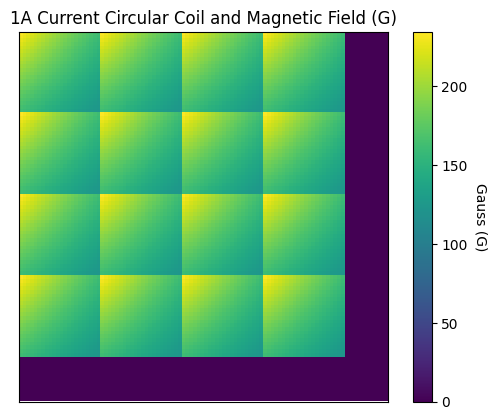

In [39]:
fig,ax = plt.subplots()
plt.title("1A Current Circular Coil and Magnetic Field (G)")

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())

im = ax.imshow(mags*10000)  # Convert to Gauss units
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Gauss (G)", rotation=-90, va="bottom")

plt.show()

In [31]:
mags = cutoffPercentile(magnitudes[ :, meshsize, :], 99.999)
mags.shape

(200, 200)

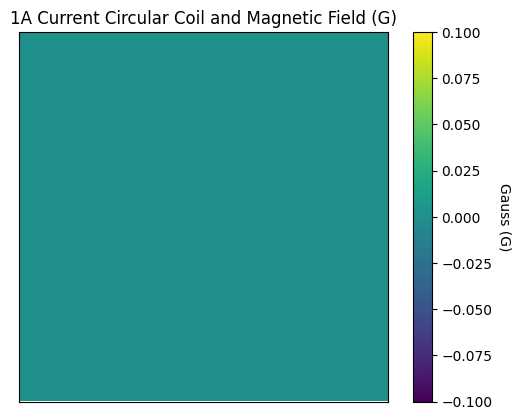

In [32]:
fig,ax = plt.subplots()
plt.title("1A Current Circular Coil and Magnetic Field (G)")

ax.xaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())

im = ax.imshow(mags.T*10000)  # Convert to Gauss units
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Gauss (G)", rotation=-90, va="bottom")

plt.show()

In [33]:
xgrid, zgrid, _ = createXZGrid(bbox, meshsize*2)

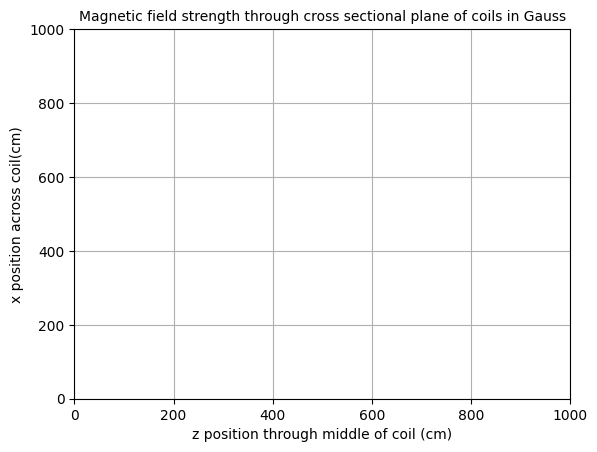

In [34]:
fig,ax = plt.subplots()
CS = ax.contour(xgrid*100, zgrid*100, mags.T*10000, levels=(0.0001,0.0005, 0.003))
ax.clabel(CS, inline=True, fontsize=8)
ax.grid()
ax.set_title("Magnetic field strength through cross sectional plane of coils in Gauss", fontsize=10)
ax.set(ylabel='x position across coil(cm)', xlabel='z position through middle of coil (cm)')
plt.show()